# Task 1
Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.style
import matplotlib as mpl

from scipy import linalg

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=150

#Useful for debugging problems
print(tf.__version__)

2025-03-01 02:10:29.942331: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 02:10:32.366418: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 02:10:35.057456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740795037.378441  479796 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740795037.978037  479796 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 02:10:39.541911: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

2.18.0


In [2]:
import h5py
import enum 

class Interaction(enum.Enum):
    kNumuQE = 0             # Numu CC QE interaction
    kNumuRes =1             # Numu CC Resonant interaction
    kNumuDIS = 2            # Numu CC DIS interaction
    kNumuOther = 3          # Numu CC, other than above
    kNueQE = 4              # Nue CC QE interaction
    kNueRes = 5             # Nue CC Resonant interaction
    kNueDIS = 6             # Nue CC DIS interaction
    kNueOther = 7           # Nue CC, other than above
    kNutauQE = 8            # Nutau CC QE interaction
    kNutauRes = 9           # Nutau CC Resonant interaction
    kNutauDIS = 10          # Nutau CC DIS interaction
    kNutauOther = 11        # Nutau CC, other than above
    kNuElectronElastic = 12 # NC Nu On E Scattering
    kNC = 13                # NC interaction
    kCosmic = 14            # Cosmic ray background
    kOther = 15             # Something else.  Tau?  Hopefully we don't use this
    kNIntType = 16          # Number of interaction types, used like a vector size


class FinalState(enum.Enum):
    kNumu0tr0sh=0                    # Numu CC - no track no shower
    kNumu0tr1sh=1                    # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 shower
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()            # NC CC - no track no shower
    kNC0tr1sh=enum.auto()            # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()            # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()            # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()            # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()            # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()            # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()            # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()            # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()            # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()            # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()            # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()            # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()            # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()            # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()            # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()            # Cosmic ray background
    kOtherFS=enum.auto()             # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size

In [3]:
# import the urllib library
import urllib.request

# Copy a network object to a local file
#urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

# Open the local h5 file with h5py
df=h5py.File('nova/neutrino1.h5','r')

In [4]:
# Print the keys in the neutrino meta data
print(df.keys())
print(df['neutrino'].keys())

# Get a numpy array containing the event image, and reshape it from flat to 2x100x80
print(np.shape(df['cvnmap']))
print(df['neutrino']['evt'])
event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
(7001, 16000)
<HDF5 dataset "evt": shape (7001, 1), type "<u4">


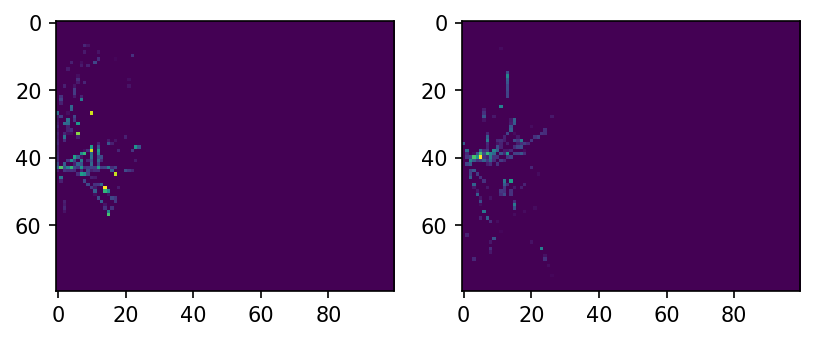

In [5]:
# Plot the first event, it is a nice long muon track
fig, ax = plt.subplots(1,2)
ax[0].imshow(event0[1].T)
ax[1].imshow(event0[0].T)

(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.        ,  8.22953796, 16.45907593, 24.68861389, 32.91815186,
        41.14768982, 49.37722778, 57.60676575, 65.83630371, 74.06584167,
        82.29537964]),
 <BarContainer object of 10 artists>)

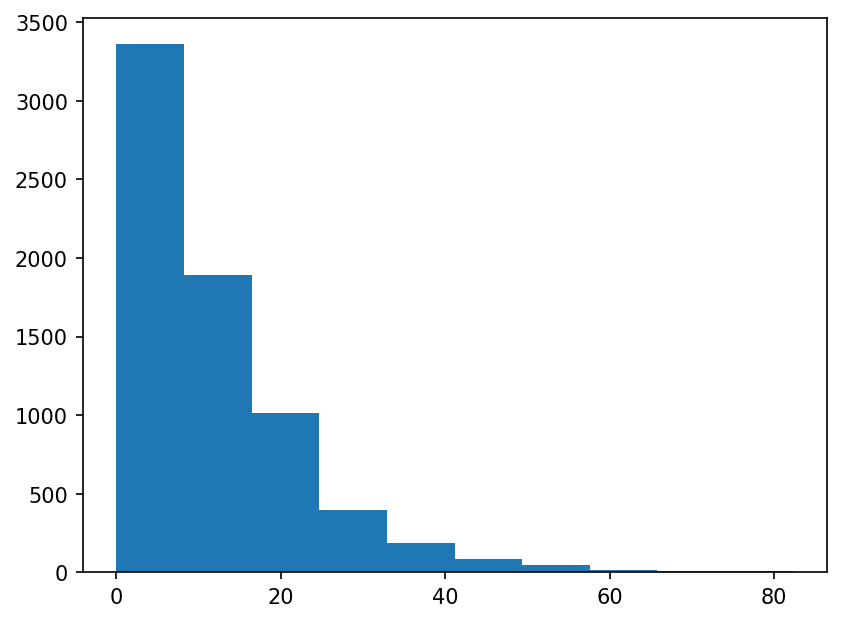

In [6]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy)

In [7]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(x_train_og, y_train), (x_test_og, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Preprocess the data

# Normalize the pixel values to be between 0 and 1
x_train = x_train_og / 255
x_test = x_test_og / 255

# Reshape for CNN input as CNNs process images as 3D tensors (height, width, channels), greyscale so 1 channel
x_train = x_train.reshape((-1, 28, 28, 1)) # -1 at front to add channel dimension
x_test = x_test.reshape((-1, 28, 28, 1))

# Build the model
def buildModel():
    """
    Builds a convolutional neural network model for image classification.

    Returns:
    keras.models.Sequential: The compiled neural network model
    """
    # Define the model
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Train the model
base_model = buildModel()
base_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the model
_, test_acc = base_model.evaluate(x_test, y_test) # "_" is used to ignore the loss value
print(f"Test Accuracy: {test_acc:.4f}")

/home/moistgooseberry/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-01 02:10:51.280512: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8643 - loss: 0.4433 - val_accuracy: 0.9845 - val_loss: 0.0574
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9806 - loss: 0.0613 - val_accuracy: 0.9875 - val_loss: 0.0470
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9881 - loss: 0.0392 - val_accuracy: 0.9873 - val_loss: 0.0453
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9901 - loss: 0.0301 - val_accuracy: 0.9882 - val_loss: 0.0408
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9931 - loss: 0.0227 - val_accuracy: 0.9910 - val_loss: 0.0349
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9880 - loss: 0.0386
Test Accuracy: 0.9903
